In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
num_points = 5000
split_index = int(0.7 * num_points)
x_min, x_max = 0.1, 2000

epochs = 5000
lr = 0.001
weight_decay = 1e-5

batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_workers = 0

In [3]:
class LogPredictor(nn.Module):
    def __init__(self):
        super(LogPredictor, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

model = LogPredictor().to(device)

In [4]:
X_set = torch.linspace(x_min, x_max, num_points).unsqueeze(1)
y_set = torch.log(X_set)

train_dataset = TensorDataset(X_set[:split_index], y_set[:split_index])
val_dataset = TensorDataset(X_set[split_index:], y_set[split_index:])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

In [5]:
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

In [6]:
for epoch in range(1, epochs):
    model.train()
    count = 1
    
    for x, y in train_dataloader:
        x: torch.Tensor = x.to(device)
        y: torch.Tensor = y.to(device)
        optimizer.zero_grad()
        pred: torch.Tensor = model(x)
        loss: torch.Tensor = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if count > 0 and epoch % (epochs // 10) == 0:
            print(f"( {epoch} ) Loss: {loss.item():.4f}; ln({x[0, 0]:.4f}) = {pred[0, 0]:.4f} ({y[0, 0]:.4f})")
            count -= 1

( 500 ) Loss: 0.0767; ln(0.1000) = -1.7026 (-2.3026)
( 1000 ) Loss: 0.5371; ln(0.1000) = -0.8537 (-2.3026)
( 1500 ) Loss: 0.0204; ln(0.1000) = -2.0478 (-2.3026)
( 2000 ) Loss: 0.9116; ln(0.1000) = -0.4269 (-2.3026)
( 2500 ) Loss: 0.1254; ln(0.1000) = -2.8022 (-2.3026)
( 3000 ) Loss: 0.0217; ln(0.1000) = -1.9868 (-2.3026)
( 3500 ) Loss: 0.0042; ln(0.1000) = -2.4116 (-2.3026)
( 4000 ) Loss: 0.0554; ln(0.1000) = -2.5699 (-2.3026)
( 4500 ) Loss: 0.0670; ln(0.1000) = -2.6507 (-2.3026)


In [7]:
def Inference(loader: DataLoader, list: list):
    for x, y in loader:
        x: torch.Tensor = x.to(device)
        y: torch.Tensor = y.to(device)
        pred: torch.Tensor = model(x)
        list.append([x[0, 0].item(), pred[0, 0].item()])

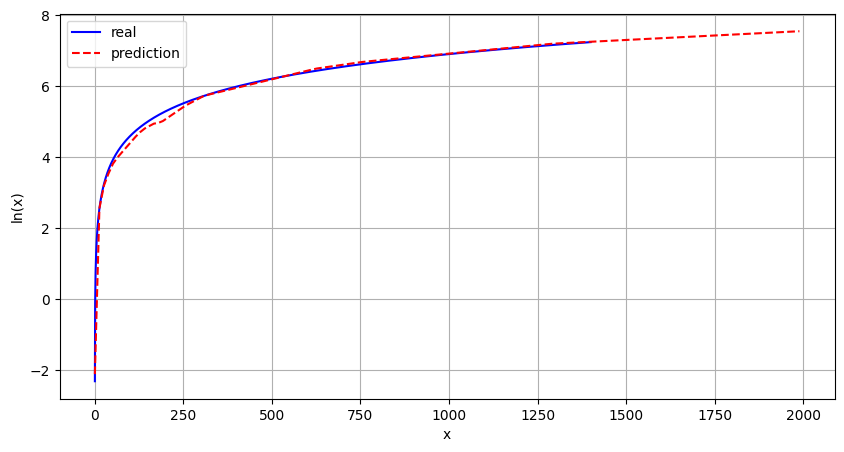

In [18]:
predictions = []

model.eval()
with torch.no_grad():
    Inference(train_dataloader, predictions)
    Inference(val_dataloader, predictions)

predictions = np.array(predictions)

plt.figure(figsize=(10, 5))
plt.plot(train_dataset[:, 0][0], train_dataset[:, 0][1], label='real', color='blue')
plt.plot(predictions[:, 0], predictions[:, 1], label='prediction', color='red', linestyle='--')
plt.xlabel("x")
plt.ylabel("ln(x)")
plt.legend()
plt.grid(True)
plt.show()

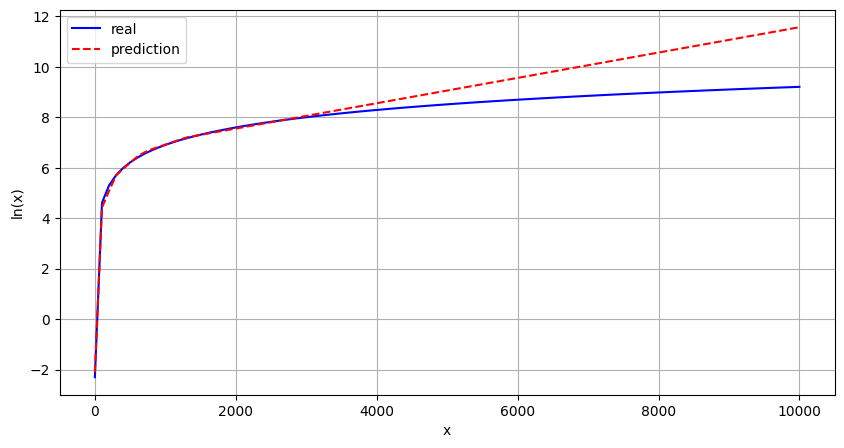

In [29]:
predictions = []
test_data = torch.linspace(x_min, 10000, 100).unsqueeze(1)

model.eval()
with torch.no_grad():
    for data in test_data:
        pred: torch.Tensor = model(data)
        predictions.append([data[0].item(), pred[0].item()])

predictions = np.array(predictions)

plt.figure(figsize=(10, 5))
plt.plot(test_data[:, 0], torch.log(test_data)[:, 0], label='real', color='blue')
plt.plot(predictions[:, 0], predictions[:, 1], label='prediction', color='red', linestyle='--')
plt.xlabel("x")
plt.ylabel("ln(x)")
plt.legend()
plt.grid(True)
plt.show()